In [84]:
%load_ext autoreload
%autoreload 2

import sys  # noqa

from mabwiser.mab import LearningPolicy  # noqa
import matplotlib.pyplot as plt  # noqa
import pandas as pd  # noqa
import seaborn as sns  # noqa

pd.set_option("display.max_rows", 300)  # Set the number of rows to display to 100

sys.path.append("..")

from backend.llm.mab_router import MABRouter  # noqa: E402
from backend.llm.ranking import Battle, ChoixRanker  # noqa: E402

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Load LS data; see ls_elo_comparison.ipynb
df = pd.read_csv("../../lmsys-arena-human-preference-55k/train.csv")


# The original LS code references a "winner" column, but this is not in the dataset, add it here.
def get_winner(row):
    if row["winner_tie"] == 1:
        return "tie"
    elif row["winner_model_a"] == 1:
        return "model_a"
    elif row["winner_model_b"] == 1:
        return "model_b"
    raise ValueError(f"Unknown winner: {row['winner_model_a']}, {row['winner_model_b']}, {row['winner_tie']}")


df["winner"] = df.apply(get_winner, axis=1)
df.head(3)

,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie,winner
0,30192,gpt-4-1106-preview,gpt-4-0613,"[""Is it morally right to try to have a certain...","[""The question of whether it is morally right ...","[""As an AI, I don't have personal beliefs or o...",1,0,0,model_a
1,53567,koala-13b,gpt-4-0613,"[""What is the difference between marriage lice...","[""A marriage license is a legal document that ...","[""A marriage license and a marriage certificat...",0,1,0,model_b
2,65089,gpt-3.5-turbo-0613,mistral-medium,"[""explain function calling. how would you call...","[""Function calling is the process of invoking ...","[""Function calling is the process of invoking ...",0,0,1,tie


In [164]:
models = set(df.model_a.unique()) | set(df.model_b.unique())

router = MABRouter(
    arms=list(models),
    learning_policy=LearningPolicy.EpsilonGreedy(epsilon=0.15),
)

arm_df = pd.DataFrame()
for i, row in df.iterrows():
    arms = [row["model_a"], row["model_b"]]
    if row["winner_tie"]:
        rewards = [0.5, 0.5]
    elif row["winner"] == "model_a":
        rewards = [1, 0]
    else:
        rewards = [0, 1]
    router.update(arms, rewards)
    if i % 2500 == 0 and i > 0:
        expectations = router.mab.predict_expectations()
        arm_df_i = pd.DataFrame(list(expectations.items()), columns=["model", f"rank_{i}"])
        if arm_df.empty:
            arm_df = arm_df_i
        else:
            arm_df = pd.merge(arm_df, arm_df_i, on="model", how="inner")

arm_df.head(3)

,model,rank_2500,rank_5000,rank_7500,rank_10000,rank_12500,rank_15000,rank_17500,rank_20000,rank_22500,...,rank_32500,rank_35000,rank_37500,rank_40000,rank_42500,rank_45000,rank_47500,rank_50000,rank_52500,rank_55000
0,llama2-70b-steerlm-chat,0.295455,0.220360,0.398734,0.401786,0.392086,0.407975,0.424623,0.435556,0.435115,...,0.429134,0.854716,0.430751,0.422566,0.421712,0.425097,0.425319,0.426724,0.420361,0.423729
1,gpt-3.5-turbo-1106,0.393382,0.184372,0.428241,0.419271,0.413649,0.419355,0.418227,0.427773,0.429008,...,0.422953,0.144677,0.419370,0.419089,0.418810,0.416950,0.417774,0.417977,0.418673,0.415397
2,nous-hermes-2-mixtral-8x7b-dpo,0.361111,0.175906,0.425000,0.451613,0.474684,0.456044,0.469697,0.460870,0.448819,...,0.454802,0.179241,0.464286,0.468468,0.469957,0.459677,0.468627,0.449640,0.454237,0.461415


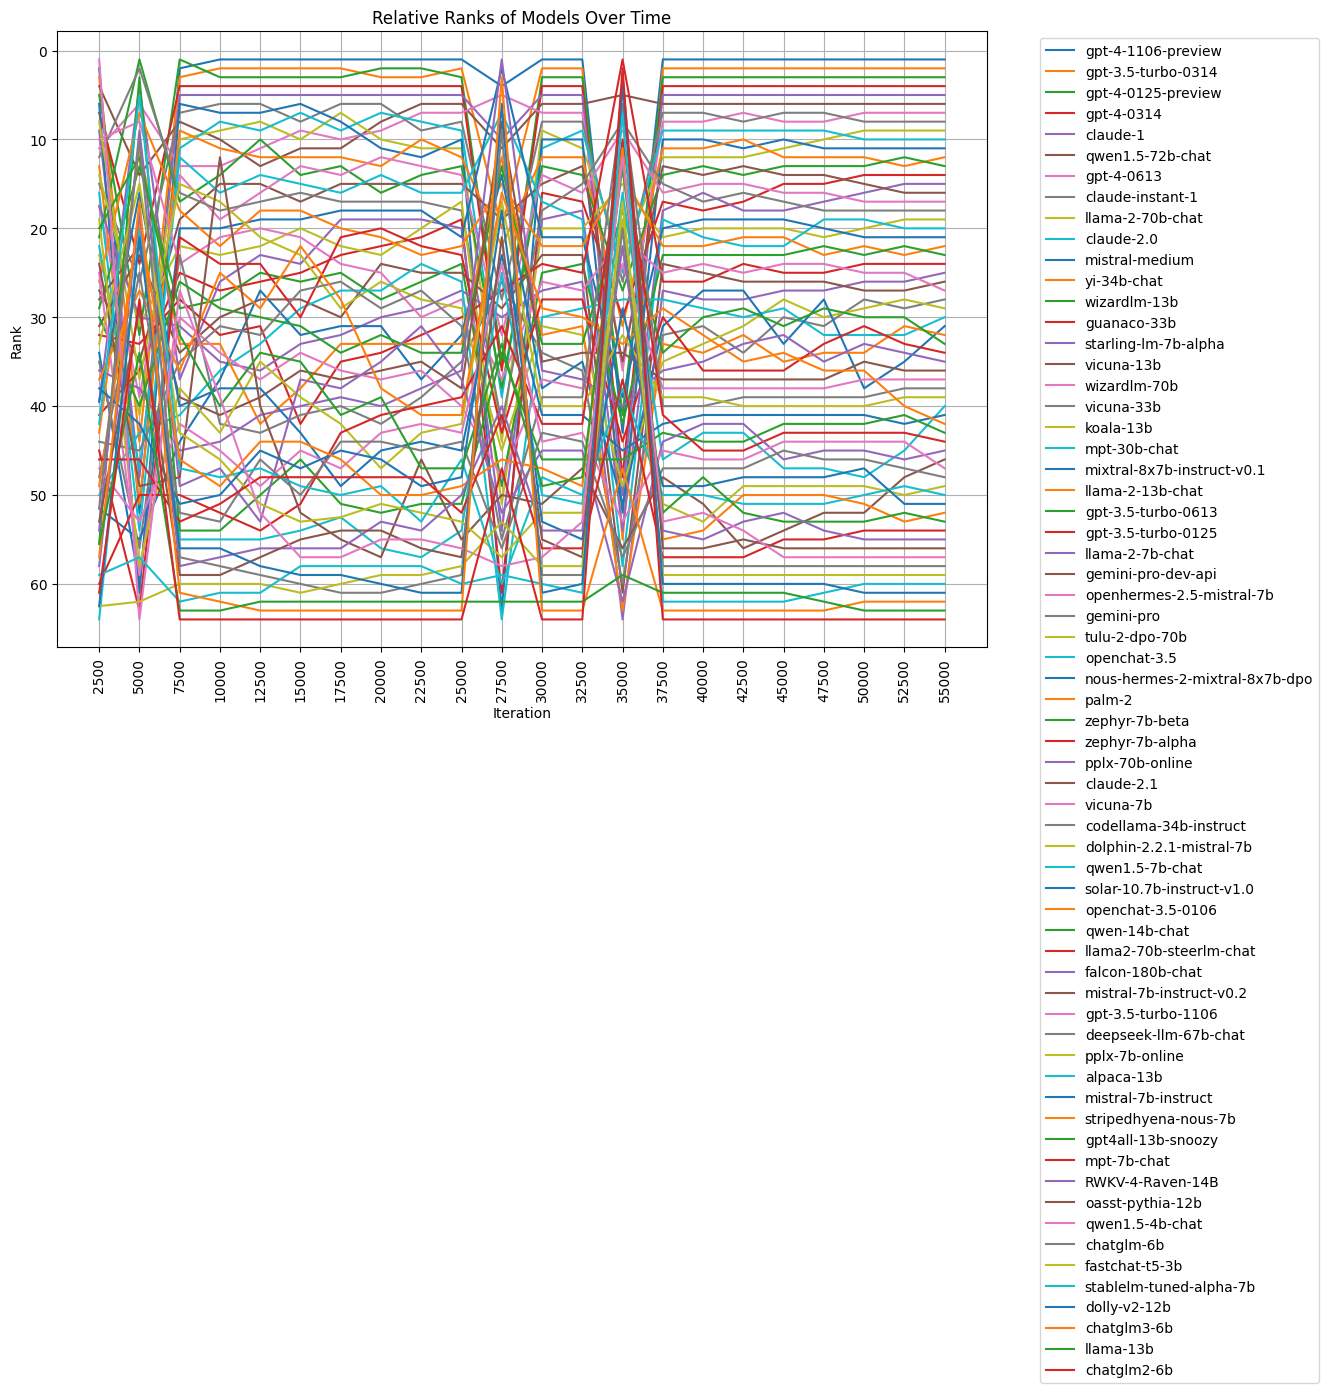

In [165]:
def plot_ranked_df(model_df: pd.DataFrame):
    rank_columns = [col for col in model_df.columns if col.startswith("rank_")]
    rank_columns_sorted = sorted(rank_columns, key=lambda x: int(x.split("_")[1]))

    # Calculate the ranks of the arms for each expectation column in ascending order
    rank_df = model_df.set_index("model")[rank_columns_sorted].rank(ascending=False)

    # Sort arms by their final rank in ascending order
    final_ranks = rank_df[rank_columns_sorted[-1]].sort_values().index

    # Plot the ranks over time using seaborn
    plt.figure(figsize=(12, 8))
    for arm in final_ranks:
        sns.lineplot(data=rank_df.loc[arm], label=arm)

    plt.xlabel("Iteration")
    plt.ylabel("Rank")
    plt.title("Relative Ranks of Models Over Time")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.grid(True)
    plt.xticks(
        ticks=range(len(rank_columns_sorted)),
        labels=[int(col.split("_")[1]) for col in rank_columns_sorted],
        rotation=90,
    )
    plt.gca().invert_yaxis()  # Invert the y-axis to have rank 1 at the top
    plt.show()


plot_ranked_df(arm_df)

In [117]:
# Convert the dataset to a list of battles, our internal representation.
def row_to_battle(row):
    if row.winner_model_b == 1:
        result = 0
    elif row.winner_model_a == 1:
        result = 1
    elif row.winner_tie == 1:
        result = 0.5
    else:
        raise ValueError(f"Unknown winner: {row}")
    return Battle(row.model_a, row.model_b, result)


battles = [row_to_battle(row) for _, row in df.iterrows()]

elo_rank_df = pd.DataFrame()
for i in range(4000, len(battles), 4000):
    ranker = ChoixRanker(battles[:i], choix_ranker_algorithm="ilsr_pairwise")
    leaderboard = ranker.leaderboard()
    leaderboard_df = pd.DataFrame([item.to_dict() for item in leaderboard])
    leaderboard_df.rename(columns={"rank": f"rank_{i}"}, inplace=True)
    leaderboard_df.drop(columns=["annotation"], inplace=True)
    if elo_rank_df.empty:
        elo_rank_df = leaderboard_df
    else:
        elo_rank_df = pd.merge(elo_rank_df, leaderboard_df, on="model", how="inner")

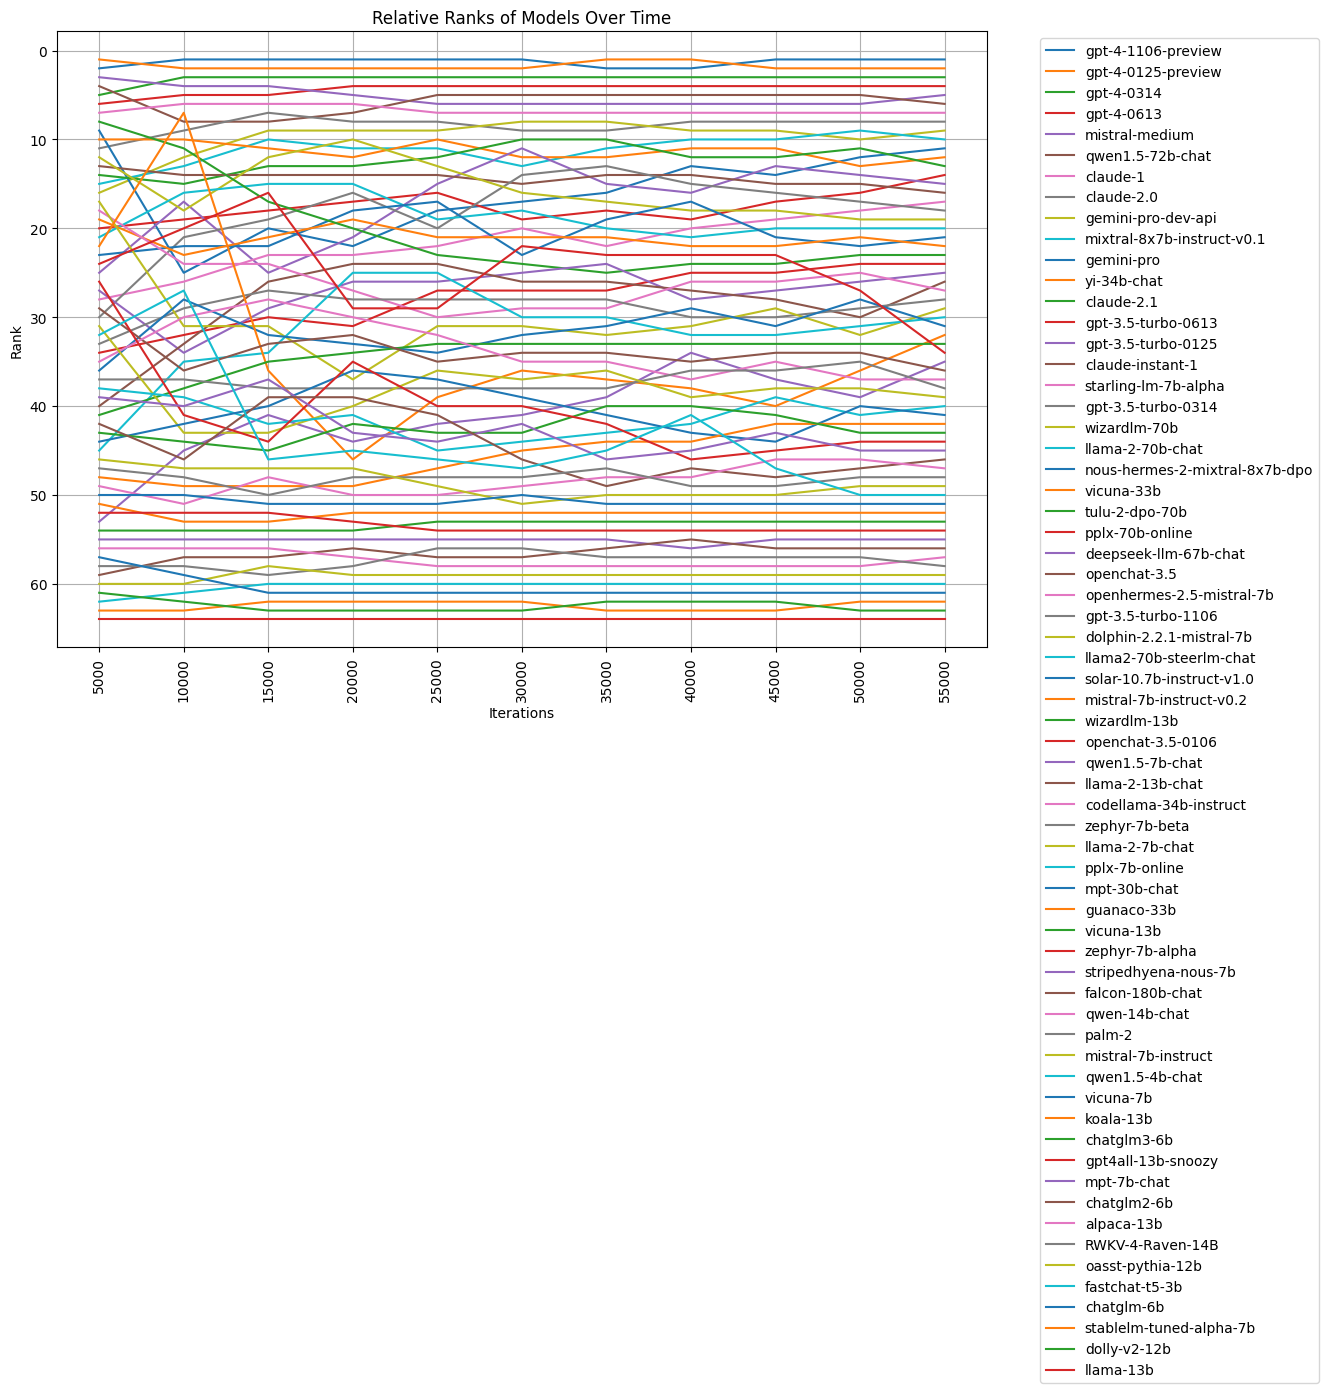

In [110]:
plot_ranked_df(elo_rank_df)

In [182]:
from collections import Counter

prob_counts = Counter([tuple(router.select_arms(2, policy="probability")) for _ in range(1000)]).most_common(10)
prob_counts

[(('gpt-4-0613', 'qwen-14b-chat'), 4),
 (('zephyr-7b-beta', 'wizardlm-13b'), 3),
 (('guanaco-33b', 'gemini-pro'), 3),
 (('guanaco-33b', 'falcon-180b-chat'), 3),
 (('llama-2-7b-chat', 'codellama-34b-instruct'), 3),
 (('qwen1.5-72b-chat', 'gpt-4-1106-preview'), 3),
 (('llama-2-70b-chat', 'zephyr-7b-beta'), 3),
 (('gpt-3.5-turbo-0314', 'wizardlm-70b'), 3),
 (('llama-13b', 'llama2-70b-steerlm-chat'), 3),
 (('stripedhyena-nous-7b', 'gpt-3.5-turbo-0613'), 2)]

In [183]:
best_counts = Counter([tuple(router.select_arms(2, policy="best")) for _ in range(1000)]).most_common(10)
best_counts

[(('gpt-4-1106-preview', 'gpt-3.5-turbo-0314'), 858),
 (('gpt4all-13b-snoozy', 'openchat-3.5'), 2),
 (('dolphin-2.2.1-mistral-7b', 'gpt-4-0613'), 1),
 (('qwen-14b-chat', 'RWKV-4-Raven-14B'), 1),
 (('gemini-pro-dev-api', 'gpt-4-0125-preview'), 1),
 (('koala-13b', 'gpt-4-0613'), 1),
 (('openhermes-2.5-mistral-7b', 'wizardlm-13b'), 1),
 (('mistral-7b-instruct-v0.2', 'yi-34b-chat'), 1),
 (('qwen1.5-7b-chat', 'gpt-3.5-turbo-1106'), 1),
 (('wizardlm-70b', 'wizardlm-13b'), 1)]